# **Tutorial 2: Reconstructing Past Changes in Ocean Climate**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Brodie Pearson, Ohad Zivan 

**Content editors:** Yosmely Bermúdez, Dionessa Biton, Agustina Pesce, Zahra Khodakaramimaghsoud

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

### **Code and Data Sources**

Code for this tutorial is based on existing notebooks from LinkedEarth that uses the `Pyleoclim` package to [assess variability in the El Nino](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L0_a_quickstart.ipynb). 

Data from the following sources are used in this tutorial:


*  Cobb,K., et al., Highly Variable El Niño–Southern Oscillation Throughout the Holocene.Science 339, 67-70(2013). https://doi.org/10.1126/science.1228246

* Cobb, K., Charles, C., Cheng, H. et al. El Niño/Southern Oscillation and tropical Pacific climate during the last millennium. Nature 424, 271–276 (2003). https://doi.org/10.1038/nature01779
















# **Tutorial Objectives**

In the previous days, we have learned about the foundational principles of the El Niño–Southern Oscillation (ENSO) and have explored how satellite data can be employed to track this phenomenon. In this tutorial, we will explore how oxygen isotopes of corals can record past changes in temperature associated with the phase of ENSO.

By the end of this tutorial you will be able to:

*   Understand types of marine proxies that are used to reconstruct climate
*   Create a stacked plot and warming stripe to compare ENSO temperature reconstructions


# **Setup**


In [1]:
# # Install libraries
# !pip install Pandas
# !pip install pooch
# !pip install cartopy
# !pip install pyleoclim

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import pooch
import cartopy
import pyleoclim as pyleo

# Section 1: Assessing El Niño Variability Using Pyleoclim Series

The paleoclimate proxy records we'll be using today are oxygen isotope records from corals. As we learned in the video, the oxygen isotopes of corals record changes in sea-surface temperature (SST). The two coral records we'll look at are from [Palmyra Atoll](https://en.wikipedia.org/wiki/Palmyra_Atoll) and [Line Islands](https://en.wikipedia.org/wiki/Line_Islands), both of which are in the tropical central Pacific Ocean. The location of these corals makes them particularly useful for understanding past changes in the El Niño-Southern Oscillation (ENSO). As explained in previous days, ENSO is a recurring climate pattern involving changes in SST in the central and eastern tropical Pacific Ocean. 

To analyze and visualize paleoclimate proxy time series, we will be using [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/), which is the same Python package we used in the previous tutorial. As a reminder, Pycleoclim is specifically designed for the analysis of paleoclimate data. The package is designed around object-oriented `Series`, which can be directly manipulated for plotting and time series-appropriate analysis and operation. 

The `Series` object describes the fundamentals of a time series. To create a Pyleoclim `Series`, we first need to load the data set, and then specify values for its various properties:

*   `time`: Time values for the time series
*   `value`: Paleo values for the time series
*   `time_name` (optional): Name of the time vector, (e.g., 'Time', 'Age'). This is used to label the x-axis on plots
*   `time_unit` (optional): The units of the time axis (e.g., 'years')
*   `value_name` (optional): The name of the paleo variable (e.g., 'Temperature')
*   `value_unit` (optional): The units of the paleo variable (e.g., 'deg C')
*   `label` (optional): Name of the time series (e.g., 'Nino 3.4')
*   `clean_ts` (optional): If True (default), remove NaNs and set an increasing time axis


## Section 1.1: Load coral oxygen isotope proxy reconstructions

Proxy-based reconstructions of temperature can also be used to understand ENSO variability. As we learned in the introductory video, oxygen isotopes of corals are a commonly used proxy for reconstructing changes in tropical Pacific SST and ENSO. The SST proxy reconstructions that we will be using are from [Cobb et al.(2003)](https://www.nature.com/articles/nature01779) (downloaded from the [NOAA Paleoclimate Database](https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/palmyra_2003.txt )) and [Cobb et al.(2013)](https://www.science.org/doi/10.1126/science.1228246) (downloaded from the [NOAA Paleoclimate Database](https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/cobb2013-fan-modsplice-noaa.txt)).


A common data format for datasets downloaded from the NOAA Paleoclimate Database is a templated text file, which contains helpful data and metadata. We can treat the file as a raw text file, ignoring the header and loading the data directly into a `pandas.DataFrame`.

### Section 1.1.1: Load Palmyra coral data

In [4]:
# Download the data using the url
data_path = pooch.retrieve(
    url='https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/palmyra_2003.txt',
    known_hash=None
)
# From the data set, we only want the data related to Modern Living Coral.
# So this data is between row 6190 and 7539 of the dataset
rows = [int(row) for row in np.linspace(6190, 7539, 7539 - 6190 + 1)]
palmyra = pd.read_csv(
    data_path,
    skiprows=lambda x: x not in rows,
    sep='\s+',
    encoding = 'ISO-8859-1',
    names=['CalendarDate', 'd180'],
    header=None,
)

palmyra.head()

,CalendarDate,d180
0,1886.13,-4.79
1,1886.21,-4.89
2,1886.29,-4.81
3,1886.38,-4.84
4,1886.46,-4.85



Notice how `pooch` retrieved the data over the network, without needing to download a local copy of the file. However, it would work just as well if you did have such a copy on your hardrive, and you would simply replace `path` with the local file path (everything else would stay the same). We use `pandas.read_csv`
to load the dataset with different arguments. The `skiprows` argument is set the number of header lines to skip, which is determined by looking at the original text file. The separator (`sep`) argument is set to `'\s+'`, which means "space". These arguments may not work on all NOAA text files, and should be adjusted based on the specific NOAA text file you are using.

Now that we have the data in a dataframe, we can pull the relevant columns of this datframe into a `Series` object in Pyleoclim, which will allow us to organize the relevant metadata so that we can get a well-labeled, publication-quality plot:

In [5]:
ts_palmyra = pyleo.Series(
    time=palmyra['CalendarDate'],
    value=palmyra['d180'],
    time_name='Calendar date',
    time_unit='Years',
    value_name = r'$d18O$',
    value_unit='per mille',
    label='Palmyra Coral'
)

Time axis values sorted in ascending order


Since we want to compare two SST datasets based on different measurements (observations and proxies), it's helpful to standardize the data:

In [6]:
palmyra_stnd = ts_palmyra.standardize()

### Section 1.1.2: Load Line Island coral data

In [7]:
# Download the data using the url
data_path2 = pooch.retrieve(
    url='https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/cobb2013-fan-modsplice-noaa.txt',
    known_hash=None
)
# From the data set, we only want the data related to Modern Living Coral.
# So this data is between row 6190 and 7539 of the dataset
rows = [int(row) for row in np.linspace(127, 800, 800 - 127 + 1)]
line = pd.read_csv(
    data_path2, 
    skiprows=lambda x: x not in rows, 
    sep='\s+',
    encoding = 'ISO-8859-1',
    names=['age', 'd18O'],
    header=None,
)

line.head()

,age,d18O
0,1949.54,-4.62
1,1949.63,-4.76
2,1949.71,-4.73
3,1949.79,-4.66
4,1949.88,-4.60


In [8]:
ts_line = pyleo.Series(
    time=line['age'],
    value=line['d18O'],
    time_name='Calendar date',
    time_unit='Years',
    value_name = r'$d18O$',
    value_unit='per mille',
    label='Line Island Coral'
)

Time axis values sorted in ascending order


In [9]:
line_stnd = ts_line.standardize()

## Section 1.2: Plot the data using multiseries

To create a `pyleo.MultipleSeries`, we first create a list with our `pyleo.Series` objects and then pass this into a `pyleo.MultipleSeries`.

In [10]:
nino_comparison = [palmyra_stnd, line_stnd]

In [11]:
nino = pyleo.MultipleSeries(nino_comparison, name='El Nino Comparison')

C:\Users\ohadz\AppData\Local\Temp\ipykernel_1604\3017497690.py:1: DeprecationWarning: `name` is a deprecated property, which will be removed in future releases, Please use `label` instead
  nino = pyleo.MultipleSeries(nino_comparison, name='El Nino Comparison')


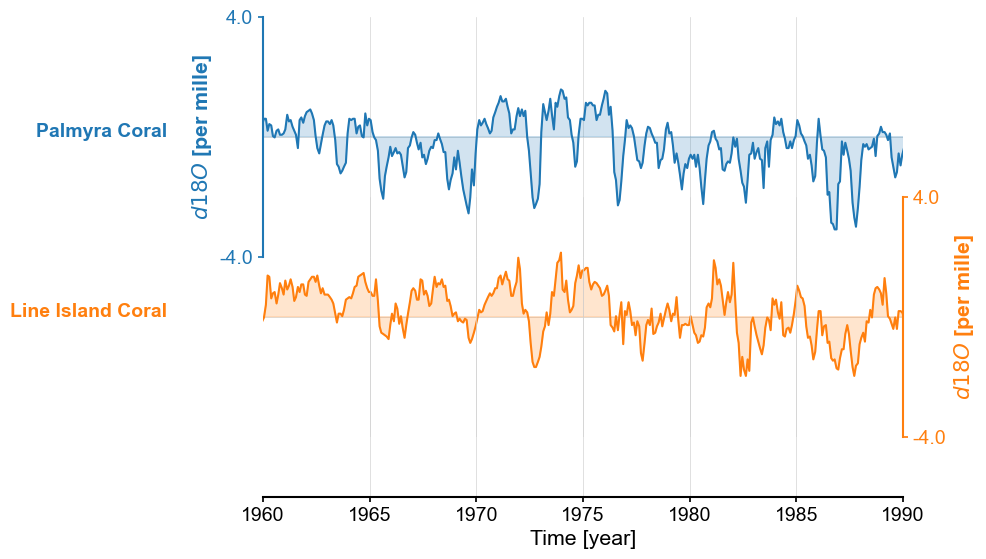

In [12]:
# Plot the time series
fig, ax = nino.stackplot(time_unit="year",xlim=[1960,1990])

We can also make a warming stripe for this `Series`, where darker red stripes indicate a warmer eastern Pacific and El Niño phase, and darker blue stripes indicate a cooler eastern Pacific and La Niña phase.

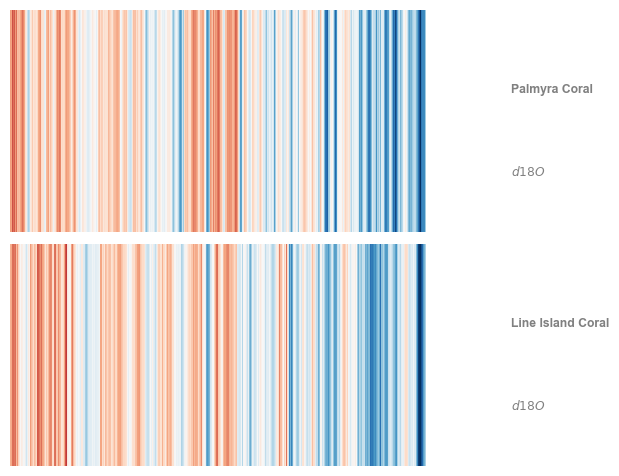

In [13]:
fig, ax = nino.stripes(ref_period=(1960,1990), time_unit="year")

## Questions:
Based on the time series and warming stripe, what do you notice about the changes in SST?

*   When were the strongest El Niño and La Niña during this time period?
*   One what timescale does the ENSO phase vary?
*   Based on the warming stripes between the two records, do you think these corals are from a similar or different region of the Pacific Ocean?


In [14]:
## to remove explanation  
print ("""
When d18O values are low, it corresponds to El Niño phase, while high d18O values correspond to La Niña phase. Put your observations here. We observed similar warming strip patterns in Palmyra Coral and Line Island Coral, indicating they are from the same region.
""")


When d18O values are low, it corresponds to El Niño phase, while high d18O values correspond to La Niña phase. Put your observations here. We observed similar warming strip patterns in Palmyra Coral and Line Island Coral, indicating they are from the same region.



# **Summary**
In this tutorial, we expanded our exploration of the ENSO by shifting our focus to the past. We discovered how oxygen isotopes within corals serve as an invaluable archive, recording changes in temperature associated with ENSO phases.

During our explorations, 
- We ventured into the study of proxy-based coral SST records, gaining insights into the rich historical climate data encapsulated within these marine structures.
- We probed into the changes in the ENSO over the past 120 years, offering us a glimpse into the dynamic nature of this influential climate phenomenon.